In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import pickle
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from trackml.utils import add_position_quantities, add_momentum_quantities
import math
import matplotlib.pyplot as plt

In [2]:
model = tf.keras.models.load_model('trained_models/Extrap_RNN_windowSize3', compile=False)
#model = tf.keras.models.load_model('trained_models/Extrap_RNN_windowSize3_local', compile=False)
#cyl_model = tf.keras.models.load_model('trained_models/Extrap_RNN_windowSize3_cyldindrical', compile=False)
z_model = tf.keras.models.load_model('trained_models/Extrap_RNN_windowSize3_zOnly', compile=False)
rho_model = tf.keras.models.load_model('trained_models/Extrap_RNN_windowSize3_rhoOnly', compile=False)
phi_model = tf.keras.models.load_model('trained_models/Extrap_RNN_windowSize3_phiOnly', compile=False)

In [3]:
def get_theta(r, z):
    if z == 0:
        return 0

    sign = 1
    if z < 0:
        sign = -1
        z = abs(z)
    theta = math.atan(r/float(z))
    return theta

def displacement(true_hit, pred_hit):
    
    x_true = true_hit[0]
    y_true = true_hit[1]
    z_true = true_hit[2]
    
    x_pred = pred_hit[0]
    y_pred = pred_hit[1]
    z_pred = pred_hit[2]
    
    return np.sqrt((x_true - x_pred)**2 + (y_true-y_pred)**2 + (z_true-z_pred)**2)

In [4]:
def dataWindow(window_size, tracks, layer_info, pt, n_features=3):
    #Input (tracks) should be an array of shape (n_samples, n_hits*n_features where the features are listed as x0, y0, z0, x1, y2, z2, ...)
    # returns an x array of size (n_samples, window_size, n_features)
    # returns a y array of size (n_samples, n_features)
    seeds = {}
    targets = {}
    pts = []
    track_list = []
    trackSeed_idx = []
    track_idx = 0 
    #for i in range(1):
    for i in range(tracks.shape[0]):
        detector_layers = layer_info.iloc[i][15:]
        detector_volumes = layer_info.iloc[i][0:15]
        track = tracks[i]
        x=track[0:15]
        y=track[15:30]
        z=track[30:]
        new_track = None
        prev_layer_id = -999
        prev_volume_id = -999
        for j in range(15):
            layer_id = detector_layers[j]
            volume_id = detector_volumes[j]
            
            # if the hit is in the same volume as the previous hit, ensure it is in the next consecutive layer
            if volume_id == prev_volume_id:
                if layer_id == prev_layer_id +1:
                    hit = np.array([x[j], y[j], z[j]])
                    if np.any(hit) == 0: break
                    prev_layer_id = layer_id
                    if np.any(new_track) is None: 
                        new_track = hit
                    else: 
                        new_track = np.vstack([new_track,hit])
                else: continue
                    
            else: 
                hit = np.array([x[j], y[j], z[j]])
                if np.any(hit) == 0: break
                prev_layer_id = layer_id
                prev_volume_id = volume_id
                if np.any(new_track) is None: 
                    new_track = hit
                else: 
                    new_track = np.vstack([new_track,hit])
            
        if len(new_track) > window_size+1:
            track_list.append(track)
        else:
            continue
        
        seeds[i] = None
        targets[i] = None
        n_hits = new_track.shape[0]
        
        for w in range(n_hits - window_size):
            seed = new_track[w:w+window_size]
            target = new_track[w+window_size]
            
            if seeds[i] is None:
                seeds[i] = seed
                targets[i] = target
            else:
                seeds[i] = np.append(seeds[i], seed, axis=0)
                targets[i] = np.append(targets[i], target, axis=0)
            pts.append(pt[i])
            trackSeed_idx.append(track_idx)
        track_idx += 1
    
    x = None
    y = None
    for key in seeds.keys():
        if x is None:
            x = seeds[key]
            y = targets[key]
        else:
            x = np.append(x, seeds[key])
            y = np.append(y, targets[key])


    return x.reshape(-1,window_size,3), y.reshape(-1,3), pts

In [5]:
x = None
y = None
filepath = 'local_data/extrapData/'
for f in os.listdir(filepath)[5:8]:
    if "_R" in f: continue
    print(f)
    with open(filepath+f, 'rb') as pFile:
            _ = pickle.load(pFile, encoding='latin1')
            _ = pickle.load(pFile, encoding='latin1')

            x_train = pickle.load(pFile, encoding='latin1')
            x_test = pickle.load(pFile,  encoding='latin1')
            x_train_flat = pickle.load(pFile,  encoding='latin1')
            x_test_flat = pickle.load(pFile,  encoding='latin1')
            x_train_layer = pickle.load(pFile,  encoding='latin1')
            x_test_layer = pickle.load(pFile,  encoding='latin1')

            _ = pickle.load(pFile,  encoding='latin1')
            _ =  pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')

            y_train = pickle.load(pFile,  encoding='latin1')
            y_test = pickle.load(pFile,  encoding='latin1')
            
            _ = pickle.load(pFile,  encoding='latin1')
            _ = pickle.load(pFile,  encoding='latin1')
            
            pt_train = pickle.load(pFile,  encoding='latin1')
            pt_test = pickle.load(pFile,  encoding='latin1')
            
    x_data, y_data, pt_data = dataWindow(3, x_train_flat, x_train_layer, pt_train)
    x_data_test, y_data_test, pt_data_test = dataWindow(3, x_test_flat, x_test_layer, pt_test)

    if x is None:
        x = x_data
        y = y_data
        pt = pt_data
        x = np.append(x, x_data_test, axis=0)
        y = np.append(y, y_data_test, axis=0)
        pt = np.append(pt, pt_data_test, axis=0)
    else:
        x = np.append(x, x_data, axis=0)
        y = np.append(y, y_data, axis=0)
        pt = np.append(pt, pt_data, axis=0)
        x = np.append(x, x_data_test, axis=0)
        y = np.append(y, y_data_test, axis=0)
        pt = np.append(pt, pt_data_test, axis=0)

Athena_ttbar_mu200_10.pkl
Athena_ttbar_mu200_12.pkl
Athena_ttbar_mu0_2.pkl


In [6]:
xPhi = np.arctan2(x[:,:,1].flatten(), x[:,:,0].flatten()) / np.pi
xPhi = xPhi.reshape(-1,3,1)
yPhi = np.arctan2(y[:,1].flatten(), y[:,0].flatten()) / np.pi
yPhi = yPhi.reshape(-1,1)

xRho = np.sqrt((x[:,:,1].flatten())**2 + (x[:,:,0].flatten())**2) 
xRho = xRho.reshape(-1,3,1)
yRho = np.sqrt((y[:,1].flatten())**2 + (y[:,0].flatten())**2)
yRho = yRho.reshape(-1,1)

x_cyl = np.append(xRho, x[:,:,2].reshape(-1,3,1), axis=2)
del xRho
x_cyl = np.append(x_cyl, xPhi, axis=2)
del xPhi
y_cyl = np.append(yRho, y[:,2].reshape(-1,1), axis=1)
#del yRho
y_cyl = np.append(y_cyl, yPhi, axis=1)
#del yPhi

In [7]:
y[:,0] = y[:, 0]*1015
y[:,1] = y[:, 1]*1015
y[:,2] = y[:, 2]*3000

In [8]:
# plot displacement error as function of z, rho
predictions = model.predict(x)
predictions[:,0] = predictions[:, 0]*1015
predictions[:,1] = predictions[:, 1]*1015
predictions[:,2] = predictions[:, 2]*3000

predictions_z = z_model.predict(x) * 3000
predictions_rho = rho_model.predict(x) * 1015
predictions_phi = phi_model.predict(x) * np.pi

#cyl_predictions = cyl_model.predict(x_cyl)
# cyl_predictions = cyl_model.predict(x_cyl)
# cyl_predictions[:,0] = cyl_predictions[:, 0]*1015 #rho
# cyl_predictions[:,2] = cyl_predictions[:, 2]*np.pi #phi
# cyl_predictions[:,1] = cyl_predictions[:, 1]*3000 #z


cart_phi = []
for ii in predictions:
    cart_phi.append(np.arctan2(ii[1], ii[0]))
    
cart_rho = []
for ii in predictions:
    cart_rho.append(np.sqrt(ii[1]**2+ ii[0]**2))

Text(0.5, 1.0, 'distribution of predicted values')

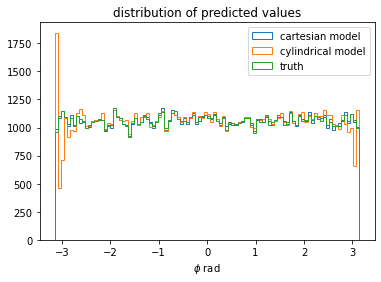

In [13]:
plt.hist(cart_phi, bins=100, histtype='step', label='cartesian model');
plt.hist(cyl_predictions[:,2], bins=100,histtype='step', label='cylindrical model');
plt.hist(yPhi*np.pi, bins=100,histtype='step', label='truth');

plt.xlabel(r'$\phi$ rad')
plt.legend()
plt.title('distribution of predicted values')

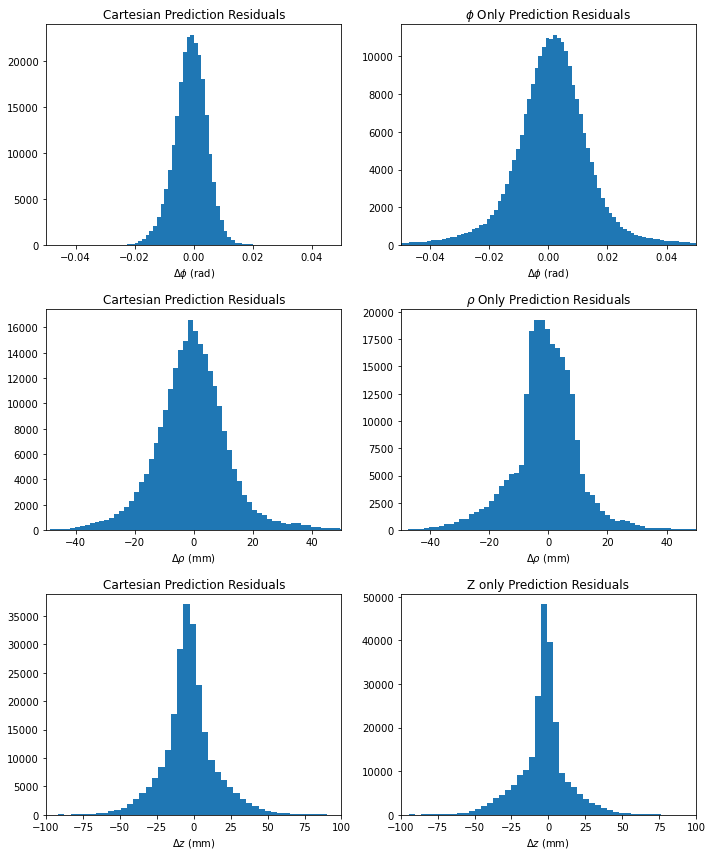

In [25]:
fig, axs = plt.subplots(3,2, figsize=(10,12))
axs[0,0].hist(yPhi.flatten()*np.pi - np.array(cart_phi), bins=10000);
axs[0,0].set_xlim([-.05,.05])
axs[0,0].set_xlabel(r'$\Delta \phi$ (rad)')
axs[0,0].set_title("Cartesian Prediction Residuals")

diff = yPhi.flatten()*np.pi - predictions_phi[:,0] #phi
axs[0,1].hist(diff, bins=10000);
axs[0,1].set_xlim([-.05,.05])
axs[0,1].set_xlabel(r'$\Delta \phi$ (rad)')
axs[0,1].set_title(r"$\phi$ Only Prediction Residuals")

axs[1,0].hist(yRho.flatten()*1015 - np.array(cart_rho), bins=100);
axs[1,0].set_xlim([-50,50])
axs[1,0].set_xlabel(r'$\Delta \rho$ (mm)')
axs[1,0].set_title("Cartesian Prediction Residuals")

diff1 = yRho.flatten()*1015 - predictions_rho[:, 0] #rho
axs[1,1].hist(diff1, bins=100);
axs[1,1].set_xlim([-50,50])
axs[1,1].set_xlabel(r'$\Delta \rho$ (mm)')
axs[1,1].set_title(r"$\rho$ Only Prediction Residuals")

axs[2,0].hist(np.array(y[:,2]-predictions[:,2]), bins=100);
axs[2,0].set_xlim([-100,100])
axs[2,0].set_xlabel(r'$\Delta z$ (mm)')
axs[2,0].set_title("Cartesian Prediction Residuals")

diff2 = y[:,2] - predictions_z[:, 0] #z
axs[2,1].hist(diff2, bins=100);
axs[2,1].set_xlim([-100,100])
axs[2,1].set_xlabel(r'$\Delta z$ (mm)')
axs[2,1].set_title("Z only Prediction Residuals")
fig.tight_layout()

In [12]:
fig, axs = plt.subplots(3,1, figsize=(10,12))
axs[0].hist(yPhi.flatten()*np.pi - np.array(cart_phi), bins=10000, label='cartesian', histtype='step', density=True);
axs[0].set_xlim([-.05,.05])
axs[0].set_xlabel(r'$\Delta \phi$ (rad)')
axs[0].set_title("Prediction Residuals")

diff = yPhi.flatten()*np.pi - predictions_phi[:,0] #phi
axs[0].hist(diff, bins=10000, label=r'$\phi$ only', histtype='step', density=True);
axs[0].set_xlim([-.05,.05])
axs[0].set_xlabel(r'$\Delta \phi$ (rad)')
axs[0].legend()

axs[1].hist(yRho.flatten()*1015 - np.array(cart_rho), bins=100, label='cartesian', histtype='step', density=True);
axs[1].set_xlim([-50,50])

diff1 = yRho.flatten()*1015 - predictions_rho[:, 0] #rho
axs[1].hist(diff1, bins=100, label=r"$\rho$ Only", histtype='step', density=True);
axs[1].set_xlabel(r'$\Delta \rho$ (mm)')
axs[1].legend()

axs[2].hist(np.array(y[:,2]-predictions[:,2]), bins=100, histtype='step', density=True, label='cartesian');
axs[2].set_xlim([-100,100])
axs[2].set_xlabel(r'$\Delta z$ (mm)')

diff2 = y[:,2] - predictions_z[:, 0] #z
axs[2].hist(diff2, bins=100, label='z only', histtype='step', density=True);
axs[2].set_xlabel(r'$\Delta z$ (mm)')
axs[2].legend()
fig.tight_layout()

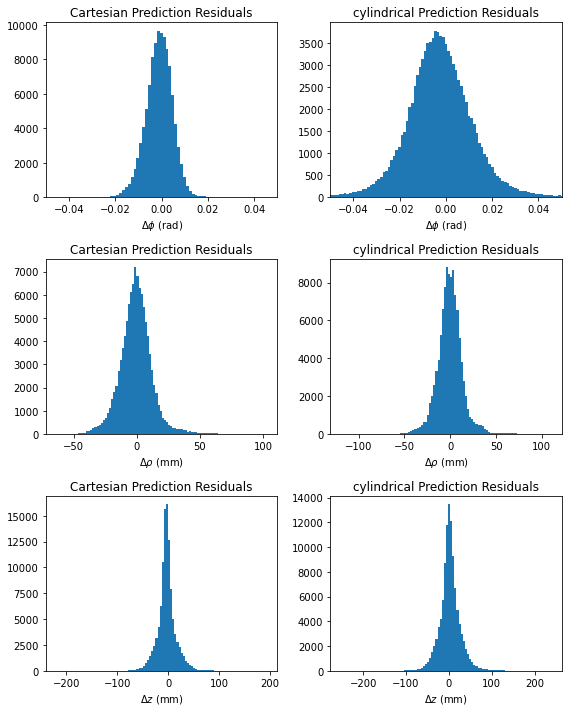

In [14]:
fig, axs = plt.subplots(3,2, figsize=(8,10))
axs[0,0].hist(yPhi.flatten()*np.pi - np.array(cart_phi), bins=1000);
axs[0,0].set_xlim([-.05,.05])
axs[0,0].set_xlabel(r'$\Delta \phi$ (rad)')
axs[0,0].set_title("Cartesian Prediction Residuals")

diff = yPhi.flatten()*np.pi - cyl_predictions[:, 2] #phi
axs[0,1].hist(diff, bins=10000);
axs[0,1].set_xlim([-.05,.05])
axs[0,1].set_xlabel(r'$\Delta \phi$ (rad)')
axs[0,1].set_title("cylindrical Prediction Residuals")

axs[1,0].hist(yRho.flatten()*1015 - np.array(cart_rho), bins=100);
#axs[1,0].set_xlim([-.05,.05])
axs[1,0].set_xlabel(r'$\Delta \rho$ (mm)')
axs[1,0].set_title("Cartesian Prediction Residuals")

diff1 = yRho.flatten()*1015 - cyl_predictions[:, 0] #rho
axs[1,1].hist(diff1, bins=100);
#axs[1,1].set_xlim([-.05,.05])
axs[1,1].set_xlabel(r'$\Delta \rho$ (mm)')
axs[1,1].set_title("cylindrical Prediction Residuals")

axs[2,0].hist(np.array(y[:,2]-predictions[:,2]), bins=100);
#axs[1,0].set_xlim([-.05,.05])
axs[2,0].set_xlabel(r'$\Delta z$ (mm)')
axs[2,0].set_title("Cartesian Prediction Residuals")

diff2 = y[:,2] - cyl_predictions[:, 1] #z
axs[2,1].hist(diff2, bins=100);
#axs[1,1].set_xlim([-.05,.05])
axs[2,1].set_xlabel(r'$\Delta z$ (mm)')
axs[2,1].set_title("cylindrical Prediction Residuals")
fig.tight_layout()

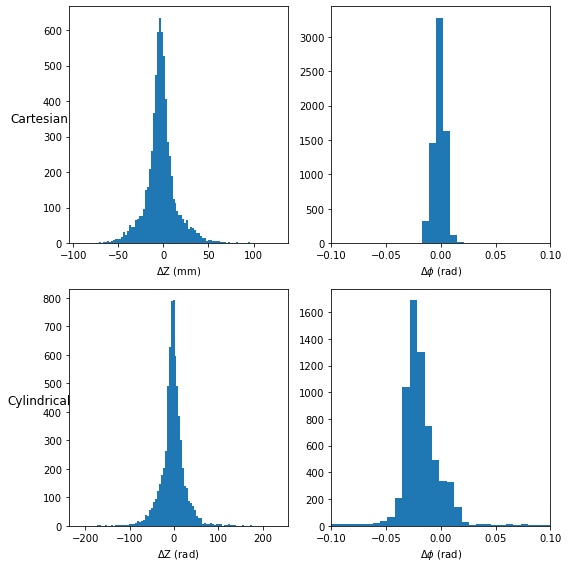

In [54]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].hist((y[:,2] - predictions[:,2]), bins=100);
axs[0,0].set_xlabel(r'$\Delta$Z (mm)')
#axs[0].set_Yscale('log')

diff = yPhi.flatten()*np.pi - np.array(cart_phi)
diff[np.where(abs(diff)<np.pi)[0]]
axs[0,1].hist(diff, bins=1000);
axs[0,1].set_xlabel(r'$\Delta \phi$ (rad)')
axs[0,1].set_xlim([-.1,.1])

axs[1,0].hist((y[:,2] - cyl_predictions[:,1]), bins=100);
axs[1,0].set_xlabel(r'$\Delta$Z (rad)')

axs[1,1].hist((yPhi.flatten()*np.pi - cyl_predictions[:,0]), bins=1000);
axs[1,1].set_xlabel(r'$\Delta \phi$ (rad)')
axs[1,1].set_xlim([-.1,.1])
#axs[1].set_Yscale('log')

rows = ['Cartesian', 'Cylindrical']
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')
fig.tight_layout()

In [ ]:
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='scatter_density')
density = ax.scatter_density(Y[:,2], err)
ax.set_xlabel('z (mm)')
ax.set_ylabel('displacement (mm)')
ax.set_ylim([0, 20])
ax.set_xlim([-1000, 1000])
fig.colorbar(density)
#axs[0].set_yscale('log')

# axs[1].scatter(y_rho, err, marker='.')
# axs[1].set_xlabel('rho (mm)')
# axs[1].set_ylabel('displacement (mm)')
# #axs[1].set_yscale('log')

In [ ]:
### -1<z<-.5 left endcap
### .5<z1 right endcap
### -.5<z<.5 barrel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, coordinate='z', **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(10,10))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    #x += .1
    #y += .1
    #z += .1
    ax.scatter( x, y, c=z, **kwargs )
    ax.set_xlabel('{} (mm)'.format(coordinate))
    ax.set_ylabel('displacement error (mm)')
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    ax.set_ylim([0, 50])

    return ax, z

In [ ]:
xt,yt = (y[:,2], np.array(err))
data , x_e, y_e = np.histogram2d( xt, yt,( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) bins = 20, density = True )
z = interpn(  , data , np.vstack([xt,yt]).T , method = "splinef2d", bounds_error = False)

In [ ]:
ax, z = density_scatter(y[:,2], np.array(err), sort=True)

In [ ]:
density_scatter(y_rho, err, sort=False, coordinate='rho')

In [ ]:
from scipy.stats import gaussian_kde

xy = np.vstack([y[:,2], np.array(err)])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()

In [ ]:
y_pred_rho = []
for ii in predictions:
    y_pred_rho.append(np.sqrt(ii[0]**2 + ii[1]**2))

In [ ]:
# plot distributions of predicted rho and z
fig, axs = plt.subplots(2, figsize=(12,12))
fig.suptitle('Distribution of True and Predicted Coordinates')

axs[0].hist(y[:,2], histtype='step', bins=100, label='true')
axs[0].hist(predictions[:,2], histtype='step', bins=100, label='predicted')
axs[0].set_xlabel('z (mm)')
axs[0].set_ylabel('frequency')
axs[0].legend();
#axs[0].set_yscale('log')


axs[1].hist(np.sqrt(y[:,0]**2+y[:,1]**2), histtype='step', bins=200, label='true')
axs[1].hist(np.sqrt(predictions[:,0]**2+predictions[:,1]**2), histtype='step', bins=200, label='predicted')
axs[1].set_xlabel('rho (mm)')
axs[1].set_ylabel('frequency')
axs[1].legend();
#axs[1].set_yscale('log')

In [ ]:
np.sqrt(y[:,0]**2+y[:,1]**2)

In [ ]:
np.sqrt(87.76813**2+704.7221**2)

In [ ]:
y

In [ ]:
# plot distributions of predicted rho and z
fig, axs = plt.subplots(2, figsize=(12,12))
fig.suptitle('Distribution of True and Predicted Coordinates')

axs[0].hist(y[:,0], histtype='step', bins=100, label='true')
axs[0].hist(predictions[:,0], histtype='step', bins=100, label='predicted')
axs[0].set_xlabel('x (mm)')
axs[0].set_ylabel('frequency')
axs[0].legend();
#axs[0].set_yscale('log')


axs[1].hist(y[:,1], histtype='step', bins=100, label='true')
axs[1].hist(predictions[:,1], histtype='step', bins=100, label='predicted')
axs[1].set_xlabel('y (mm)')
axs[1].set_ylabel('frequency')
axs[1].legend();
#axs[1].set_yscale('log')

In [ ]:
plt.hist(np.arcsin(y[:,1]/y[:,0]), histtype='step', bins=100, label='true')
plt.hist(np.arcsin(predictions[:,1]/predictions[:,0]), histtype='step', bins=100, label='predicted')
plt.xlabel(r'$\phi$ (mm)')
plt.ylabel('frequency')
plt.legend();
#axs[1].set_yscale('log')

In [ ]:
plt.hist(np.arcsin(y[:,1]/y[:,0])-np.arcsin(predictions[:,1]/predictions[:,0]), histtype='step', bins=300)
plt.xlabel(r'$\phi_{truth} - \phi_{pred} $ (rad)')
plt.ylabel('frequency')
plt.xlim([-.1, .1])
plt.legend();
#axs[1].set_yscale('log')

In [ ]:
import math
res = []
for i in range(len(y)):
    deltaPhi = np.arcsin(y[i,1]/y[i,0])-np.arcsin(predictions[i,1]/predictions[i,0])
    if math.isnan(deltaPhi): continue
    res.append(deltaPhi)
np.std(res)

In [ ]:
# Plot the number of hits in an event closer than the predicted one
n_neighbors = []
for i in range(len(newdf) - 3):
    window = newdf.iloc[[i, i+1, i+2]][['x','y','z']].values
    pred = model.predict(window[np.newaxis, :])[0]
    err = displacement(newdf.iloc[i+3][['x','y','z']].values, pred)
    count = 0
    # rather than compare this to every hit, just compare to nearby ones
    xCut = .1
    yCut = .1
    zCut = .1

    nearbyHits = newdf.loc[(newdf.x >= newdf.x-xCut) & (newdf.x <= newdf.x+xCut)]
    nearbyHits = nearbyHits.loc[(nearbyHits.y >= nearbyHits.y-yCut) & (nearbyHits.y <= nearbyHits.y+yCut)]
    nearbyHits = nearbyHits.loc[(nearbyHits.z >= nearbyHits.z-zCut) & (nearbyHits.z <= nearbyHits.z+zCut)]
    for j in range(len(nearbyHits)):
        dist = displacement(nearbyHits.iloc[j][['x','y','z']].values, pred)
        if dist < err:
            count += 1
        n_neighbors.append(count)


In [ ]:
plt.hist(np.sqrt(y[:,0]**2+y[:,1]**2) - np.sqrt(predictions[:,0]**2+predictions[:,1]**2), histtype='step', bins=30)
plt.xlabel(r'$\rho_{truth} - \rho_{pred}$ (mm)')
plt.ylabel('frequency')
plt.legend();
#axs[1].set_yscale('log')

In [ ]:
# Plot errors as a function of pT

In [ ]:
from scipy.stats import binned_statistic


mean_stat = binned_statistic(pt, err, 
                             statistic='mean', 
                             bins=20, 
                             range=(min(pt), 200))

std_stat = binned_statistic(pt, err, 
                             statistic='std', 
                             bins=20, 
                             range=(min(pt), 200))

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.scatter(pt, err,marker='_', alpha=.1, color='skyblue')
plt.errorbar(mean_stat.bin_edges[:-1], mean_stat.statistic, yerr=std_stat.statistic, 
             fmt='*',
             color='black',
             lw=10,
            ecolor='black',
            elinewidth=3)
#plt.xscale('log')
plt.xlabel('$p_{T}$ [GeV]', fontsize=14);
plt.ylabel("|r-r'| error (mm)", fontsize=14);
plt.xlim([min(pt),200])
plt.ylim([-10, 200])
#plt.xscale('log')
#plt.title('Sum of Distance Between Predicted and True Hits per Track')
#plt.savefig('Etaefficiency.pdf')

In [ ]:
def get_eta(r, z):
    # eta = -ln(tan(theta/2))
    if z == 0:
        return 0

    sign = 1
    if z < 0:
        sign = -1
        z = abs(z)
    theta = math.atan(r/float(z))
    tan_theta_over_two = math.tan(theta/2.)
    try:
        eta = -math.log( tan_theta_over_two )
    except ValueError:
        print ("can't take log of", tan_theta_over_two, 'from theta =', theta)
        sys.exit()
    return eta * sign

#find eta of the first hit in every track
eta=[]
for ii in range(len(x)):
    hitx = x[ii,0,0]*1015
    hity = x[ii,0,1]*1015
    hitz = x[ii,0,2]*3000
    hitr = np.sqrt((hitx)**2 + (hity)**2 + (hitz)**2)
    eta.append(get_eta(hitr,hitz))
    
from scipy.stats import binned_statistic

mean_stat = binned_statistic(eta, err, 
                             statistic='mean', 
                             bins=20, 
                             range=(min(eta), max(eta)))

std_stat = binned_statistic(eta, err, 
                             statistic='std', 
                             bins=20, 
                             range=(min(eta), max(eta)))

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.scatter(pt, err,marker='_', alpha=.1, color='skyblue')
plt.errorbar(mean_stat.bin_edges[:-1], mean_stat.statistic, yerr=std_stat.statistic, 
             fmt='*',
             color='black',
             lw=10,
            ecolor='black',
            elinewidth=3)
#plt.xscale('log')
plt.xlabel('$\eta$ [GeV]', fontsize=14);
plt.ylabel("|r-r'| error (mm)", fontsize=14);
plt.xlim([min(eta),max(eta)])
plt.ylim([-0, 100])
#plt.xscale('log')
#plt.title('Sum of Distance Between Predicted and True Hits per Track')
#plt.savefig('Etaefficiency.pdf')

In [ ]:
plt.hist(eta)